# Recap

Raw sequencing data (`.fastq.gz`) mapped to a reference genome (`.fa.gz`) with `bwa`, creating files with mapped reads(`.bam`)

`samtools` to inspect, sort, merge, filter them

`gatk MarkDuplicates` to mark or remove PCR duplicates from the data

`mosdepth` to get coverage

Genotype calling: what is the state of an individual at a given position in the genome?

Program: `gatk HaplotypeCaller` - needs reference genome and mapped data

Output: Variant Call File (`.vcf.gz`)

`bcftools` as toolkit for inspection, filtering, etc.

`bcftools view` - can include parameters for filtering, e.g. `-m2` means at least 2 alleles

`bcftools concat` - concatenate files

`bcftools stats` - obtain useful statistics


# VCF file formats

We had generated two common types of VCF file outputs using the GATK `ERC` parameters: `BP_RESOLUTION` and `NONE`. One gives a genotype call for each position along the chromosome, the other only for positions that are different from the reference genome. The problem with the first is that it creates large files in which most positions are the same as the reference. The problem with the second is that we miss exactly where they are the same. A compromise is using the format `GVCF`, which creates a hybrid file format, in which consecutive `0/0` positions are merged.

* If not done as part of the last challenge, you may create this file by using this parameter now, for the region 1-25000000.

* Do you have it? Otherwise, we may have a look at it together.

This format is very efficient for storing large data, but it creates a mess in terms of coordinates. At more advanced levels, other tools from the `gatk` (it's a toolkit) are necessary to handle this kind of information. Also, some commands of `bcftools` need to know what is going on, *e.g.* if you want to use this program to merge data from multiple individuals.

* Now, also get the genotypes in the same format for any of the `.bam` files from the previous sessions!


## Merging

To clarify the difference between `bcftools concat` and `bcftools merge`: you concatenate different genomic positions for the same individuals, or your merge the same genomic positions for different individuals.

**Concatenating:**

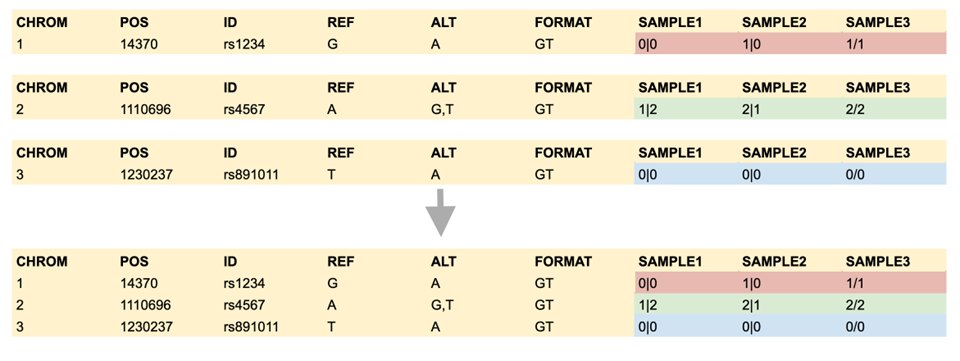

**Merging:**

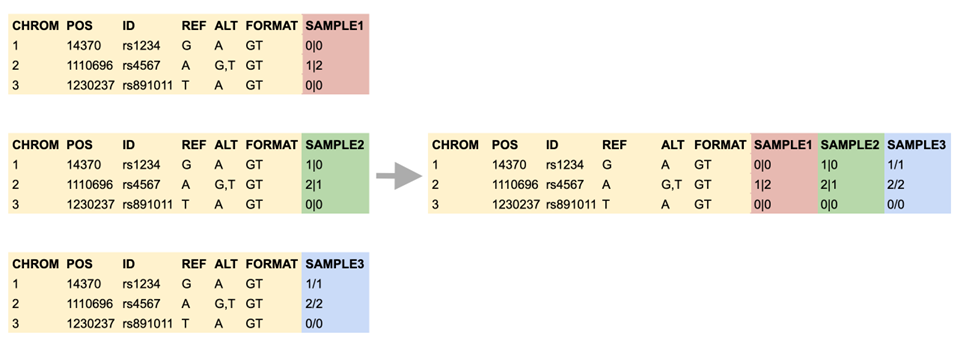

Ok, then let's merge two individuals:

```
bcftools merge -Oz -o merged_set.vcf.gz -g /home/local/ANTHROPOLOGY/kuhlwilmm83/refgen/hg19/hg19.p13.plusMT.no_alt_analysis_set.fa.gz chr18_a.vcf.gz chr18_b.vcf.gz
```

* Let's have a look at the resulting file!

Speaking about multiple individuals...


## Diversity data

### 1000 Genomes data

The 1000 Genomes Project is a commonly-used reference data resources in human genetic studies.

In the (final) phase 3 data, there are 2,504 individuals from 26 populations ([Sudmant et al. 2015](https://doi.org/10.1038/nature15394)).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/1000_Genomes_Project.svg/1280px-1000_Genomes_Project.svg.png?1657572184698" alt="1KG" width="1000"/>

**Figure 2 [Locations](https://www.wikiwand.com/en/1000_Genomes_Project#/Human_genome_samples) of population samples of 1000 Genomes Project.** Each circle represents the number of sequences in the final release.

More information can be found in their [website](https://www.internationalgenome.org/).


# Population-scale VCFs

## Extract data from a population

So, we should get data from the 1000 Genomes project:

```
wget http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr18.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
```

This is a multi-individual VCF file. This it not in the `gvcf` format, only SNPs are here, making it easier to handle.

* Let's have a look at the header as well as the metadata file provided by the project!
* Inspect the chromosome names!

```
bcftools view -h ALL.chr18.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz 

wget http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel
less integrated_call_samples_v3.20130502.ALL.panel
```


### Reference problems

Now, we encounter another typical problem - different [reference genomes](https://gatk.broadinstitute.org/hc/en-us/articles/360035891071-Reference-genome) for humans. A first problem is that existing data from different sources might have been mapped and genotype called using a newer version of the human genome ([version 38](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001405.26/): "hg38" from 2013), or the previous version ([version 19](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001405.13/) or "hg19" from 2009). These are the most common ones, and even older ones are really not recommended to use! These versions have different coordinates, so they are not compatible.

To make things worse, although there is a coordinate system for the same version numbers, with the same number of bases from start to end, there exist versions with different chromosome names ("chr18" vs. ("18"), coming from different [sources](https://genome-euro.ucsc.edu/cgi-bin/hgGateway?db=hg19&redirect=manual&source=genome.ucsc.edu)!

[Here](https://gatk.broadinstitute.org/hc/en-us/articles/360035890951-Human-genome-reference-builds-GRCh38-or-hg38-b37-hg19) is an explanation of the issue. That means, there are four different human genome versions commonly used (hg19 and hg38 with and without "chr").

**When obtaining a dataset, you always need to check which reference genome in which format was used!**

It's already a rather big file, can may see that it does contain >2M records for 2,504 individuals - a data frame of *>5.6 billion cells* for one of the smaller chromosomes... Even for the smallest human chromosome (chr21), this is >1M records!


## Subsetting data

### Subsetting regions

* With this in mind, let's subset the file to make work easier! Note how the `-r` changes!

```
bcftools index ALL.chr18.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz 
bcftools view -r 18:1-25000000 -Oz -o chr18.vcf.gz ALL.chr18.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
bcftools view -h chr18.vcf.gz
```

* Let's calculate some stats:

```
bcftools stats chr18.vcf.gz > stats_chr18.vcf.gz
bcftools index chr18.vcf.gz
```

The `index` step above is useful for retrieving subsets from the data, and generally recommendable for `vcf` files.

### Subsetting individuals

If we want to extract data from some individuals, for example, samples from the same population, we can use the argument `-S` with a file containing names of samples you want to extract. Let's assume you want to compare the Finns to the Iberians, you could use awk to create a nice list with the identifiers for each. (Btw, again a practical use case of a simple command line tool.)

```
awk '$2=="FIN" { print $1 }' integrated_call_samples_v3.20130502.ALL.panel > FIN.list
awk '$2=="IBS" { print $1 }' integrated_call_samples_v3.20130502.ALL.panel > IBS.list
```

Now, each line in these files contains one sample ID. Then we can extract genetic variants from the FIN and IBS populations with the following commands, respectively.

```
bcftools view -Oz -o chr18.FIN.vcf.gz chr18.vcf.gz -S FIN.list &
bcftools view -Oz -o chr18.IBS.vcf.gz chr18.vcf.gz -S IBS.list
```

* Now there is the `&` at the end of the line? What does this mean now?

* Let's have a look at the files!

As a result, you get a file containing the same variants as before, just for a subset of individuals instead of the whole thing.


## Quality filtering

### Subsetting SNPs by quality

When analysing data, we usually want to use variants that can meet some conditions, for example, variants with good quality.

* As before, we may extract biallelic SNPs that passed the quality checks.

```
bcftools view chr18.FIN.vcf.gz -f PASS -m 2 -M 2 -v snps | bgzip -c > chr18.FIN.biallelic.snps.vcf.gz &
bcftools view chr18.IBS.vcf.gz -f PASS -m 2 -M 2 -v snps | bgzip -c > chr18.IBS.biallelic.snps.vcf.gz
```

If we have a look at these files, we can see that they contain a lot of positions where all individuals within the population are `0/0` (or `0|0`). If were are interested in what is going on within the population, we may restrict to polymorphisms within.


### Restricting data to polymorphic sites

Looking at the [documentation](https://samtools.github.io/bcftools/bcftools.html#view) of `bcftools view`, we find the flag `-a` to trim unseen alternative alleles. In this case, one should first trim the alleles, and afterwards filter for biallelic SNPs.

* Let's trim and filter, and count how much is left in each case!

```
bcftools view chr18.FIN.vcf.gz -a | bcftools view -f PASS -m 2 -M 2 -v snps | bgzip -c > chr18.FIN.true_biallelic.snps.vcf.gz &
bcftools view chr18.IBS.vcf.gz -a | bcftools view -f PASS -m 2 -M 2 -v snps | bgzip -c > chr18.IBS.true_biallelic.snps.vcf.gz
```

* Given that the number of individuals in each dataset is similar, does it tell us something about the diversity within these populations?


### Much more filtering

Beyond the very basic filtering above, `bcftools filter` provides a variety of options of filtering. The easiest are defined with `-e` to *exclude* sites with a certain condition, and `-i` to *include* those with a certain condition.

```
bcftools filter
```

You need to provide [*expressions*](https://samtools.github.io/bcftools/bcftools.html#expressions), in a very similar way you provide *expressions* to `awk`, including comparison operators (`>=` etc), logical operators (`&&`), selection of samples with square brackets (`[5:6]`), and many more which cannot be comprehensively discussed here.

* Let's try some!

```
bcftools filter '-i GT[0]=="0|1"' chr18.vcf.gz | less

bcftools filter '-e GT[20]=="0|0"' chr18.vcf.gz | less

# to see what it is doing, look at:

bcftools filter '-e GT[20]=="0|0"' chr18.vcf.gz | grep -v "^#" | cut -f 30 | less

bcftools filter '-i GT[1]=="1|2"' chr18.vcf.gz | less
```

In the `INFO` column, there is a lot of information, such as allele frequencies (`AF`).

```
bcftools filter '-i INFO/AF>0.3' chr18.vcf.gz | less
```


The 1000 genomes file is particularly reduced, containing only genotypes. We may also try it on a more "raw" file from a previous session or the challenge.

* Just to try out some:

```
bcftools filter '-i GT=="./."' chr18_a.vcf.gz | less

bcftools filter '-i FORMAT/DP>5' chr18_a.vcf.gz | less 

bcftools filter '-e FORMAT/DP<5 && FORMAT/DP>8' chr18_a.vcf.gz | less 
```

